To do: must make it more adaptable to changes between odd vs even num of threads.

In [62]:
from PIL import Image, ImageDraw, ImageOps
import numpy as np

OVAL_RADIUS=20
LINE_THICKNESS=10
KNOT_HORIZ_SPACING=3*OVAL_RADIUS
KNOT_VERT_SPACING=int(KNOT_HORIZ_SPACING/2)-(OVAL_RADIUS)
HORIZ_MARGIN=80
VERT_MARGIN=40

black_arrows=[Image.open("Icons\FWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\FWDBWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWDFWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS))]

white_arrows=[Image.open("Icons\FWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\FWDBWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWDFWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS))]


def get_color_appropriate_arrow(arrow_index, color_hex):
    color_hex=color_hex.lstrip('#')

    r = int(color_hex[0:2], 16)
    g = int(color_hex[2:4], 16)
    b = int(color_hex[4:6], 16)

    luminance = (0.299 * r + 0.587 * g + 0.114 * b) / 255

    if(luminance<0.5): # if dark
        return white_arrows[arrow_index]
    else:
        return black_arrows[arrow_index]
    

def get_knot_result(arrow_index, left_color, right_color):
    knot_color=None
    new_left_color=None
    new_right_color=None

    if(arrow_index==0 or arrow_index==2): # fwd or fwdbwd
        knot_color=left_color
    else: # bwd or bwdfwd
        knot_color=right_color


    if(arrow_index==0 or arrow_index==1): # fwd or bwd
        new_left_color=right_color
        new_right_color=left_color
    else: # fwdbwd or bwdfwrd
        new_left_color=left_color
        new_right_color=right_color

    return knot_color, new_left_color, new_right_color


- FWD: 0
- BWD: 1
- FWDBWD: 2
- BWDFWD: 3
- NO KNOT: -1

['#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000']
['#ff0000', '#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00']
['#ff0000', '#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00']
['#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000']


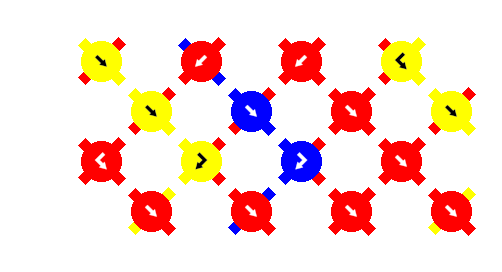

In [76]:
num_rows=4
num_threads=9
num_cols=int(np.floor(float(num_threads)/2))

#############################
# For testing
#############################

knots_array=[[0, 1, 1, 3],
             [0, 0, 0, 0],
             [3, 2, 2, 0],
             [0, 0, 0, 0]]

threads_array=[['#ffff00', '#ff0000', '#0000ff', '#ff0000','#ff0000','#ff0000','#ff0000','#ffff00','#ff0000']]

##############################

image = Image.new('RGBA',
                   (HORIZ_MARGIN*2+(num_cols*OVAL_RADIUS*2)+((num_cols-1)*KNOT_HORIZ_SPACING), VERT_MARGIN*2+(num_rows*OVAL_RADIUS*2)+((num_rows-1)*KNOT_VERT_SPACING))
                   ) # width x height
draw = ImageDraw.Draw(image)
for row in range(num_rows):
    threads_row=threads_array[-1]
    new_threads_row=[]
    if(row%2!=0): # if row is odd
        new_threads_row.append(threads_row[0])

    for col in range(num_cols):
        if(row%2==0): # if row is even
            oval_x_start=int(HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
            left_in=threads_row[col*2]
            right_in=threads_row[(col*2)+1]
        else: # if row is odd
            oval_x_start=int((OVAL_RADIUS)+(KNOT_HORIZ_SPACING/2)+HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
            if(num_threads%2==0 and col==num_cols-1): # if num of threads is even and we reached end of row
                new_threads_row.append(threads_row[-1])
                continue # no knot
            left_in=threads_row[(col*2)+1]
            right_in=threads_row[(col*2)+2]
        color_hex, new_left, new_right =get_knot_result(knots_array[row][col],left_in, right_in)
        
        oval_y_start=int(VERT_MARGIN+(2*row*OVAL_RADIUS)+(row*KNOT_VERT_SPACING))

        #if(row==0): # if first row
        draw.line([(oval_x_start,oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=left_in, width=LINE_THICKNESS)
        draw.line([(oval_x_start+(2*OVAL_RADIUS),oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=right_in, width=LINE_THICKNESS)
        #if(row==num_rows-1): # if last row
        draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start+(2*OVAL_RADIUS),oval_y_start+(2*OVAL_RADIUS))], fill=new_right, width=LINE_THICKNESS)
        draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start,oval_y_start+(2*OVAL_RADIUS))], fill=new_left, width=LINE_THICKNESS)
        
        arrow=get_color_appropriate_arrow(knots_array[row][col], color_hex=color_hex)
        draw.ellipse((oval_x_start, oval_y_start, oval_x_start+OVAL_RADIUS*2, oval_y_start+OVAL_RADIUS*2), fill = color_hex)
        
        image.paste(arrow, (oval_x_start+int(OVAL_RADIUS/2), oval_y_start+int(OVAL_RADIUS/2)),arrow)

        new_threads_row.append(new_left)
        new_threads_row.append(new_right)
    if(num_threads%2!=0 and row%2==0):
        new_threads_row.append(threads_row[-1])
    threads_array.append(new_threads_row)
    print(new_threads_row)
#draw.line([(0,0),(500,500)], fill='red', width=LINE_THICKNESS)
image=ImageOps.expand(image, border=1, fill='white')
display(image)
